# Least-Squares 

In this problem we solve a least squares problem to "best-fit" parameters to a diffusion tensor model. However, there are a variety of options available to solve the least squares problem in terms of the cost function that will be minimized. In particular weighting, and whether minimization should be done in each coordinate direction individually or for the total flux. 

Note: This is a cleaned notebook built on top of the older version - LS_machinery_scrap.

In [1]:
import numpy as np
import xarray as xr
from funcs import *
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm

In [2]:
Lcoarse = 50e3

In [3]:
Trac_coarse = xr.open_dataset('./outputs_ncfiles/Trac_coarse_'+str(int(Lcoarse//1e3))+'km.nc')
Vels_coarse = xr.open_dataset('./outputs_ncfiles/Vels_coarse_'+str(int(Lcoarse//1e3))+'km')
T_coarse    = xr.open_dataset('./outputs_ncfiles/T_coarse_'+str(int(Lcoarse//1e3))+'km')
diff_tensor = xr.open_dataset('./outputs_ncfiles/diff_tensor_'+str(int(Lcoarse//1e3))+'km.nc')
diff_tensor_withKPP = xr.open_dataset('./outputs_ncfiles/diff_tensor_with_diff_'+str(int(Lcoarse//1e3))+'km.nc')

list_trac = ['TRAC01', 'TRAC02', 'TRAC03', 'TRAC04', 'TRAC05', 
            'TRAC06', 'TRAC07', 'TRAC08', 'TRAC09', 'TRAC10', 
            'TRAC11', 'TRAC12', 'TRAC13', 'TRAC14', 'TRAC15', 
            'TRAC16', 'TRAC17', 'TRAC18', 'TRAC19', 'TRAC20']

[UpCp, VpCp, WpCp] = get_flux_arrays(Trac_coarse, list_trac)
[dCdx, dCdy, dCdz]= get_grad_arrays(Trac_coarse, list_trac)

In [14]:
# this does the same thing as the old calc tensor; solves stacked problem,
# but does weighting but the amount of flux.
def calc_tensor_3point(uc,vc,wc, cx,cy,cz):
    Afluxu = np.array([uc]).T
    Afluxv = np.array([vc]).T
    Afluxw = np.array([wc]).T
    
    Wu = np.abs(Afluxu)
    Wv = np.abs(Afluxv)
    Ww = np.abs(Afluxw)
    
    Agrad = np.array([cx, cy, cz]).T

    if ~(np.isnan(Agrad).any()):
        
        Kx = pinv(-Agrad/Wu).dot(Afluxu/Wu)
        Ky = pinv(-Agrad/Wv).dot(Afluxv/Wv)
        Kz = pinv(-Agrad/Ww).dot(Afluxw/Ww)
    
        K = np.concatenate((Kx.T, Ky.T, Kz.T), axis=0)
        
        return(K, Kx)
    else:
        return np.nan(), np.nan

In [15]:
# calculate errors 

def calc_err(uc,vc,wc,cx,cy,cz,K):
    rU = - (K[0,0]*cx + K[0,1]*cy + K[0,2]*cz)
    rV = - (K[1,0]*cx + K[1,1]*cy + K[1,2]*cz)
    rW = - (K[2,0]*cx + K[2,1]*cy + K[2,2]*cz)    
    
    eU = np.abs(uc - rU)/np.abs(uc)
    eV = np.abs(vc - rV)/np.abs(vc)
    eW = np.abs(wc - rW)/np.abs(wc)
    
    return rU, rV, rW, eU, eV, eW

In [16]:
def calc_tensor_vec(uc,vc,wc, cx,cy,cz): 
    
    bvec = np.concatenate((uc,vc,wc))
    
    grad = np.array([cx, cy, cz]).T
    
    E1vec = np.concatenate((grad, np.zeros_like(grad), np.zeros_like(grad)), axis=1)
    E2vec = np.concatenate((np.zeros_like(grad), grad, np.zeros_like(grad)), axis=1)
    E3vec = np.concatenate((np.zeros_like(grad), np.zeros_like(grad), grad), axis=1)
    
    Evec = np.concatenate((E1vec, E2vec, E3vec), axis=0)
    
    K = -pinv(Evec).dot(bvec)
    
    K = K.reshape((3,3))
    return K

In [17]:
def calc_tensor_vec_weighted(uc,vc,wc, cx,cy,cz): 
    
    bvec = np.concatenate((uc,vc,wc))
    
    grad = np.array([cx, cy, cz]).T
    
    W = np.abs(bvec)
    
    E1vec = np.concatenate((grad, np.zeros_like(grad), np.zeros_like(grad)), axis=1)
    E2vec = np.concatenate((np.zeros_like(grad), grad, np.zeros_like(grad)), axis=1)
    E3vec = np.concatenate((np.zeros_like(grad), np.zeros_like(grad), grad), axis=1)
    
    Evec = np.concatenate((E1vec, E2vec, E3vec), axis=0)
    
    K = -pinv(Evec/W[:, None]).dot(bvec/W)
    
    K = K.reshape((3,3))
    return K

In [18]:
# Choose a location to do the analysis 
xloc= 1700e3
yloc = 1000e3
zloc =-300

In [19]:
diff_tensor

<xarray.Dataset>
Dimensions:        (XCcoarse: 40, YCcoarse: 40, Z: 40, i: 3, ii: 3, j: 3, k: 3)
Coordinates:
  * Z              (Z) float32 -5.0 -15.0 -25.0 ... -2727.5 -2830.5 -2933.5
  * YCcoarse       (YCcoarse) float32 25000.0 75000.0 ... 1925000.0 1975000.0
  * XCcoarse       (XCcoarse) float32 25000.0 75000.0 ... 1925000.0 1975000.0
    hFacCcoarse    (Z, YCcoarse, XCcoarse) float32 ...
    PHrefC         (Z) float32 ...
    drF            (Z) float32 ...
Dimensions without coordinates: i, ii, j, k
Data variables:
    Kfast          (Z, YCcoarse, XCcoarse, i, j) float32 ...
    Kslow          (Z, YCcoarse, XCcoarse, i, j) float32 ...
    Kcorr          (Z, YCcoarse, XCcoarse, i, j) float32 ...
    STcorr         (Z, YCcoarse, XCcoarse, i, j) float32 ...
    ATcorr         (Z, YCcoarse, XCcoarse, i, j) float32 ...
    eigvalsSTcorr  (Z, YCcoarse, XCcoarse, ii) float32 ...
    eigvecsSTcorr  (Z, YCcoarse, XCcoarse, k, ii) float32 ...
    STslow         (Z, YCcoarse, XCcoarse, i, j

(-900, 0)

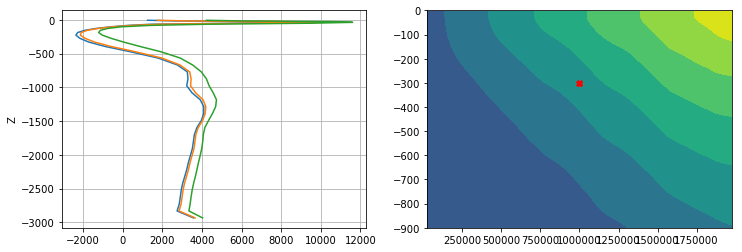

In [20]:
# A plot of a region where we see large, systematic negative eigenvalues 

# Where are we in location? 
X = T_coarse.XCcoarse
Y = T_coarse.YCcoarse
Z = T_coarse.Z

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(diff_tensor.eigvalsSTcorr.sel(XCcoarse=xloc, YCcoarse=yloc, method='nearest').isel(ii=1), Z)
plt.plot(diff_tensor.eigvalsSTslow.sel(XCcoarse=xloc, YCcoarse=yloc, method='nearest').isel(ii=1), Z)
plt.plot(diff_tensor.eigvalsSTfast.sel(XCcoarse=xloc, YCcoarse=yloc, method='nearest').isel(ii=1), Z)

# plt.plot(diff_tensor_withKPP.eigvalsST.sel(XCcoarse=xloc, YCcoarse=yloc, method='nearest').isel(ii=1), Z,'o')
plt.grid()
plt.ylabel('Z')
# the different between with and without KPP is minor (order 0.002)

plt.subplot(122)
plt.contourf(Y, Z, T_coarse['T'].sel(XCcoarse=xloc, method='nearest'))
plt.plot(yloc, zloc, 'X', color='r')
plt.ylim([-900,0])

In [21]:
## Make the data variables 

# buoyancy variables 
yub = T_coarse.UpTp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest')
yvb = T_coarse.VpTp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest')
ywb = T_coarse.WpTp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest')

E1b = T_coarse.T_X.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest')
E2b = T_coarse.T_Y.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest')
E3b = T_coarse.T_Z.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest')

# fast variables
yufast= UpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2))
yvfast= VpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2))
ywfast= WpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2))
# the number in front of E is the column number 
E1fast = dCdx.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2))
E2fast = dCdy.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2))
E3fast = dCdz.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2))

Efast = np.stack((E1fast.data, E2fast.data, E3fast.data), axis=1)

# slow variables
yuslow= UpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))
yvslow= VpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))
ywslow= WpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))
# the number in front of E is the column number 
E1slow = dCdx.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))
E2slow = dCdy.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))
E3slow = dCdz.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))

Eslow = np.stack((E1slow.data, E2slow.data, E3slow.data), axis=1)

In [22]:
# All the least squares weighted/unweighted/vector form/weighted vector form 

[Kfast, _] = calc_tensor_3point(yufast, yvfast, ywfast, E1fast, E2fast, E3fast)
[Kslow,_] = calc_tensor_3point(yuslow, yvslow, ywslow, E1slow, E2slow, E3slow)

Kfast_noweight = calc_tensor(yufast, yvfast, ywfast, E1fast, E2fast, E3fast)
Kslow_noweight = calc_tensor(yuslow, yvslow, ywslow, E1slow, E2slow, E3slow)

Kfastvec = calc_tensor_vec_weighted(yufast, yvfast, ywfast, E1fast, E2fast, E3fast)
Kfastvec_noweight = calc_tensor_vec(yufast, yvfast, ywfast, E1fast, E2fast, E3fast)

Kslowvec = calc_tensor_vec_weighted(yuslow, yvslow, ywslow, E1slow, E2slow, E3slow)
Kslowvec_noweight = calc_tensor_vec(yuslow, yvslow, ywslow, E1slow, E2slow, E3slow)

# The corrected tensors for using with buoyancy
lam1 = 1/31104000.
lam2 = 1/186624000.

Kcorr = (lam2*Kfast - lam1*Kslow)/(lam2 - lam1)
Kcorr_noweight = (lam2*Kfast_noweight - lam1*Kslow_noweight)/(lam2 - lam1)

Kcorrvec = (lam2*Kfastvec - lam1*Kslowvec)/(lam2 - lam1)
Kcorrvec_noweight = (lam2*Kfastvec_noweight - lam1*Kslowvec_noweight)/(lam2 - lam1)

In [28]:
Kfast_noweight

array([[ 1.4372177e+04, -4.7870781e+03, -4.5577191e-02],
       [-3.8371553e+03,  1.3263856e+03, -1.0687878e+00],
       [-2.4810076e-01, -3.5962954e+00,  1.9844924e-03]], dtype=float32)

In [30]:
Kfastvec_noweight

array([[ 1.4372616e+04, -4.7871362e+03, -4.6265543e-02],
       [-3.8372710e+03,  1.3264022e+03, -1.0685793e+00],
       [-2.4818382e-01, -3.5964439e+00,  1.9842917e-03]], dtype=float32)

In [23]:
# Errors in tracers

[rUfast, rVfast, rWfast, eUfast, eVfast, eWfast] = calc_err(yufast, yvfast, ywfast, E1fast, E2fast, E3fast,Kfast)
[rUslow, rVslow, rWslow, eUslow, eVslow, eWslow] = calc_err(yuslow, yvslow, ywslow, E1slow, E2slow, E3slow,Kslow)

[rUfast_noweight, rVfast_noweight, rWfast_noweight, eUfast_noweight, eVfast_noweight, eWfast_noweight] = calc_err(
    yufast, yvfast, ywfast, E1fast, E2fast, E3fast,Kfast_noweight)
[rUslow_noweight, rVslow_noweight, rWslow_noweight, eUslow_noweight, eVslow_noweight, eWslow_noweight] = calc_err(
    yuslow, yvslow, ywslow, E1slow, E2slow, E3slow,Kslow_noweight)

[rUfastvec, rVfastvec, rWfastvec, eUfastvec, eVfastvec, eWfastvec] = calc_err(yufast, yvfast, ywfast, E1fast, E2fast, E3fast,Kfastvec)
[rUslowvec, rVslowvec, rWslowvec, eUslowvec, eVslowvec, eWslowvec] = calc_err(yuslow, yvslow, ywslow, E1slow, E2slow, E3slow,Kslowvec)

[rUfastvec_noweight, rVfastvec_noweight, rWfastvec_noweight, eUfastvec_noweight, eVfastvec_noweight, eWfastvec_noweight] = calc_err(
    yufast, yvfast, ywfast, E1fast, E2fast, E3fast,Kfastvec_noweight)
[rUslowvec_noweight, rVslowvec_noweight, rWslowvec_noweight, eUslowvec_noweight, eVslowvec_noweight, eWslowvec_noweight] = calc_err(
    yuslow, yvslow, ywslow, E1slow, E2slow, E3slow,Kslowvec_noweight)

In [24]:
# Sort tracers by their fluxes 
idxfast = np.argsort(np.abs(yufast.values))
idyfast = np.argsort(np.abs(yvfast.values))
idzfast = np.argsort(np.abs(ywfast.values))

idxslow = np.argsort(np.abs(yuslow.values))
idyslow = np.argsort(np.abs(yvslow.values))
idzslow = np.argsort(np.abs(ywslow.values))

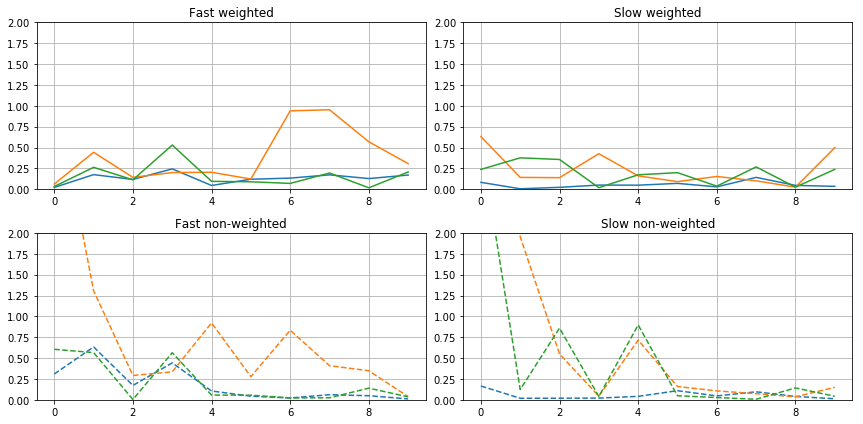

In [25]:
plt.figure(figsize=(12,6))
plt.subplot(221)
plt.plot(eUfast[idxfast])
plt.plot(eVfast[idyfast])
plt.plot(eWfast[idzfast])
plt.title('Fast weighted')
plt.ylim([0,2])
plt.grid()

plt.subplot(222)
plt.plot(eUslow[idxslow])
plt.plot(eVslow[idxslow])
plt.plot(eWslow[idxslow])
plt.title('Slow weighted')
plt.ylim([0,2])
plt.grid()

plt.subplot(223)
plt.plot(eUfast_noweight[idxfast],'--')
plt.plot(eVfast_noweight[idyfast],'--')
plt.plot(eWfast_noweight[idzfast],'--')
plt.title('Fast non-weighted')
plt.ylim([0,2])
plt.grid()

plt.subplot(224)
plt.plot(eUslow_noweight[idxslow],'--', label='X')
plt.plot(eVslow_noweight[idyslow],'--', label='Y')
plt.plot(eWslow_noweight[idzslow],'--', label='Z')
plt.title('Slow non-weighted')
plt.ylim([0,2])
plt.grid()

plt.tight_layout()

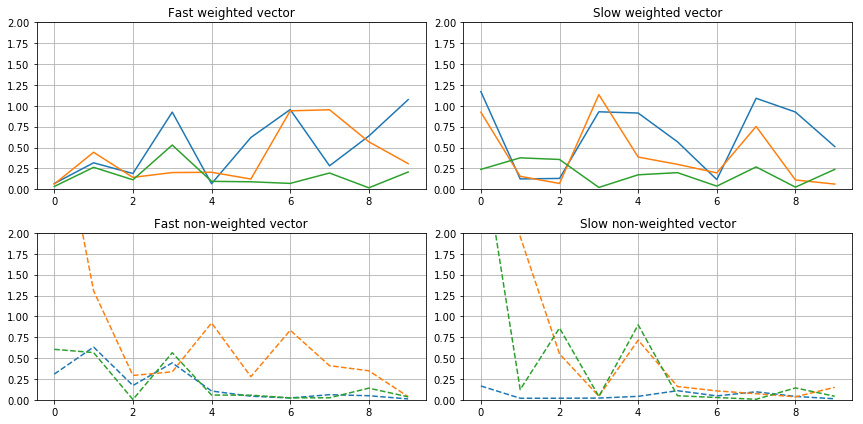

In [26]:
plt.figure(figsize=(12,6))
plt.subplot(221)
plt.plot(eUfastvec[idxfast])
plt.plot(eVfastvec[idyfast])
plt.plot(eWfastvec[idzfast])
plt.title('Fast weighted vector')
plt.ylim([0,2])
plt.grid()

plt.subplot(222)
plt.plot(eUslowvec[idxslow])
plt.plot(eVslowvec[idxslow])
plt.plot(eWslowvec[idxslow])
plt.title('Slow weighted vector')
plt.ylim([0,2])
plt.grid()

plt.subplot(223)
plt.plot(eUfastvec_noweight[idxfast],'--')
plt.plot(eVfastvec_noweight[idyfast],'--')
plt.plot(eWfastvec_noweight[idzfast],'--')
plt.title('Fast non-weighted vector')
plt.ylim([0,2])
plt.grid()

plt.subplot(224)
plt.plot(eUslowvec_noweight[idxslow],'--', label='X')
plt.plot(eVslowvec_noweight[idyslow],'--', label='Y')
plt.plot(eWslowvec_noweight[idzslow],'--', label='Z')
plt.title('Slow non-weighted vector')
plt.ylim([0,2])
plt.grid()

plt.tight_layout()

# Conclusion 

Looking at a few points in the domain to compare the 4 methods, it appears that the best performance is achieved when using weighted least squares in each direction individually. The weighted vector ends up introducing more error in the horizontal direction, without any signficant improvements in the vertical directions.

This is particularly comfoting for us because we plan to primarily use the horizontal fluxes at the end, so improvement in that direction is better. 

In [73]:
Ktensorfast3 = xr.apply_ufunc(calc_tensor_3, 
                       UpCp.sel(tracer_num=slice(1,19,2)),
                       VpCp.sel(tracer_num=slice(1,19,2)),
                       WpCp.sel(tracer_num=slice(1,19,2)),
                       dCdx.sel(tracer_num=slice(1,19,2)),
                       dCdy.sel(tracer_num=slice(1,19,2)),
                       dCdz.sel(tracer_num=slice(1,19,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

/home/dbalwada/3D_tracer_inversion/Channel_sponge/funcs.py:40: RuntimeWarning: divide by zero encountered in true_divide
  np.isinf(Agrad).any() |  np.isinf(1/Wu).any() |  np.isinf(1/Wv).any() |  np.isinf(1/Ww).any()):


In [126]:
Ktensorslow3 = xr.apply_ufunc(calc_tensor_3, 
                       UpCp.sel(tracer_num=slice(2,20,2)),
                       VpCp.sel(tracer_num=slice(2,20,2)),
                       WpCp.sel(tracer_num=slice(2,20,2)),
                       dCdx.sel(tracer_num=slice(2,20,2)),
                       dCdy.sel(tracer_num=slice(2,20,2)),
                       dCdz.sel(tracer_num=slice(2,20,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

/home/dbalwada/3D_tracer_inversion/Channel_sponge/funcs.py:40: RuntimeWarning: divide by zero encountered in true_divide
  np.isinf(Agrad).any() |  np.isinf(1/Wu).any() |  np.isinf(1/Wv).any() |  np.isinf(1/Ww).any()):


In [127]:
Kcorr3 = (lam2*Ktensorfast3 - lam1*Ktensorslow3)/(lam2 - lam1)

In [128]:
# make sure the eigen values are arranged by magnitude (instead of the default arrangement)
def eigen(A):
    if ~(np.isnan(A).any() | np.isinf(A).any()):
        eigenValues, eigenVectors = eigh(A)
        idx = np.argsort(np.abs(eigenValues))
        eigenValues = eigenValues[idx]
        eigenVectors = eigenVectors[:,idx]
        return (eigenValues, eigenVectors)
    else:
        return (np.nan, np.nan)

In [201]:
Kcorr3T = Kcorr3.transpose('Z', 'YCcoarse', 'XCcoarse', 'j','i')

ST = 0.5*(Kcorr3.data + Kcorr3T.data)
AT = 0.5*(Kcorr3.data - Kcorr3T.data)

ST = xr.DataArray(ST, coords=Kcorr3.coords, dims=Kcorr3.dims)
AT = xr.DataArray(AT, coords=Kcorr3.coords, dims=Kcorr3.dims)    



In [202]:
eigvalsST, eigvecsST = xr.apply_ufunc(eigen, ST, input_core_dims=[['i','j']],
                                vectorize=True, output_core_dims=[['ii'], ['k','ii']])

Text(0.5, 1.0, 'Non-Weighted')

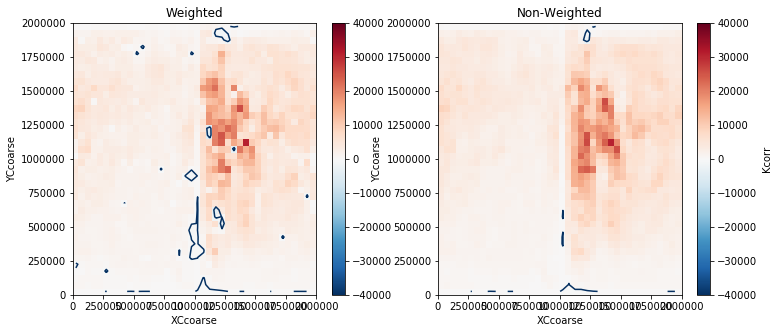

In [133]:
plt.figure(figsize=(12,5))
d=-1000
plt.subplot(121)
Kcorr3.sel(Z=d, method='nearest').isel(i=1, j=1).plot(vmax=4e4)
Kcorr3.sel(Z=d, method='nearest').isel(i=1, j=1).plot.contour(levels=[0])
plt.title('Weighted')

plt.subplot(122)
diff_tensor.Kcorr.sel(Z=d, method='nearest').isel(i=1, j=1).plot(vmax=4e4)
diff_tensor.Kcorr.sel(Z=d, method='nearest').isel(i=1, j=1).plot.contour(levels=[0])
plt.title('Non-Weighted')

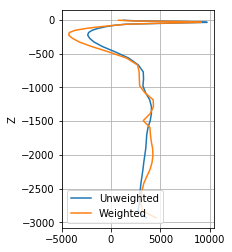

In [115]:
plt.subplot(121)
plt.plot(diff_tensor.eigvalsST.sel(XCcoarse=xloc, YCcoarse=yloc, method='nearest').isel(ii=1), Z, label='Unweighted')
plt.plot(eigvalsST.sel(XCcoarse=xloc, YCcoarse=yloc, method='nearest').isel(ii=1), Z, label='Weighted')
plt.grid()
plt.ylabel('Z')
plt.legend()

In [135]:
def flux_reconstruct(tensor, flux, grads):

    recUflux = -(tensor.sel(i=0, j=0)*grads.dCdx + tensor.sel(i=0, j=1)*grads.dCdy + tensor.sel(i=0, j=2)*grads.dCdz)
    recVflux = -(tensor.sel(i=1, j=0)*grads.dCdx + tensor.sel(i=1, j=1)*grads.dCdy + tensor.sel(i=1, j=2)*grads.dCdz)
    recWflux = -(tensor.sel(i=2, j=0)*grads.dCdx + tensor.sel(i=2, j=1)*grads.dCdy + tensor.sel(i=2, j=2)*grads.dCdz)

    errU = np.abs(flux.UpCp - recUflux)/np.abs(flux.UpCp)
    errV = np.abs(flux.VpCp - recVflux)/np.abs(flux.VpCp)
    errW = np.abs(flux.WpCp - recWflux)/np.abs(flux.WpCp)
    
    flux_rec=xr.Dataset({'UpCp':recUflux, 'VpCp':recVflux, 'WpCp':recWflux,
                                'errU':errU, 'errV':errV, 'errW':errW})
    
    return flux_rec

In [137]:
fluxT = xr.Dataset({'UpCp':T_coarse.UpTp, 'VpCp':T_coarse.VpTp, 'WpCp':T_coarse.WpTp})
gradT = xr.Dataset({'dCdx':T_coarse.T_X, 'dCdy':T_coarse.T_Y, 'dCdz':T_coarse.T_Z})
[UpCp, VpCp, WpCp] = get_flux_arrays(Trac_coarse, list_trac)
[dCdx, dCdy, dCdz]= get_grad_arrays(Trac_coarse, list_trac)
flux = xr.Dataset({'UpCp':UpCp, 'VpCp':VpCp, 'WpCp':WpCp})
grads = xr.Dataset({'dCdx':dCdx, 'dCdy':dCdy, 'dCdz':dCdz})
frtracer = flux_reconstruct(diff_tensor.Kslow, flux, grads)
frtracer3 = flux_reconstruct(Ktensorslow3, flux, grads)
frb = flux_reconstruct(diff_tensor.Kcorr, fluxT, gradT)
frb3 = flux_reconstruct(Kcorr3, fluxT, gradT)

Text(0.5, 1.0, 'Error b flux')

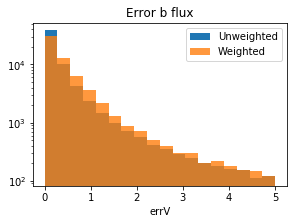

In [192]:
plt.figure(figsize=(10,3))
plt.subplot(121)
bins = np.linspace(0,5,19)
frb.errV.plot.hist(bins = bins, label='Unweighted')
bins = np.linspace(0,5,19)
frb3.errV.plot.hist(bins = bins, alpha=0.8, label='Weighted')
plt.yscale('log')
plt.legend()
plt.title('Error b flux')

Text(0.5, 1.0, 'Error Tracer fluxes')

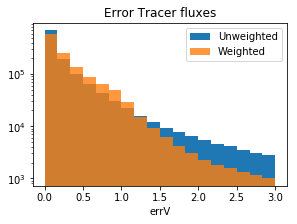

In [193]:
plt.figure(figsize=(10,3))
plt.subplot(121)
bins = np.linspace(0,3,19)
frtracer.errV.plot.hist(bins = bins, label='Unweighted')
bins = np.linspace(0,3,19)
frtracer3.errV.plot.hist(bins = bins, label='Weighted', alpha=0.8)
plt.yscale('log')
plt.legend()
plt.title('Error Tracer fluxes')

Text(0.5, 1.0, 'Error Tracer fluxes')

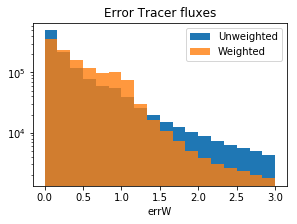

In [142]:
plt.figure(figsize=(10,3))
plt.subplot(121)
bins = np.linspace(0,3,19)
frtracer.errW.plot.hist(bins = bins, label='Unweighted')
bins = np.linspace(0,3,19)
frtracer3.errW.plot.hist(bins = bins, label='Weighted', alpha=0.8)
plt.yscale('log')
plt.legend()
plt.title('Error Tracer fluxes')

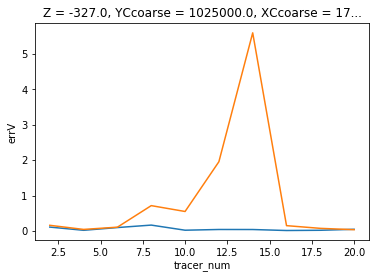

In [194]:
xloc= 1700e3
yloc = 1000e3
zloc = -300
frtracer.errU.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2)).plot()
frtracer.errV.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2)).plot()
#frtracer.errW.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2)).plot()

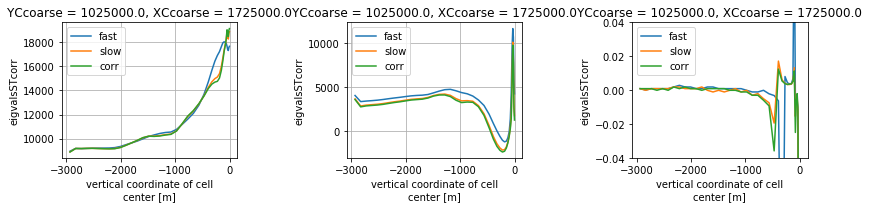

In [195]:
xloc = 1700e3
yloc = 1000e3

plt.figure(figsize=(12,3))

plt.subplot(131)
diff_tensor.eigvalsSTfast.sel( YCcoarse=yloc, XCcoarse=xloc, method='nearest').isel(ii=2).plot(label='fast')
diff_tensor.eigvalsSTslow.sel( YCcoarse=yloc, XCcoarse=xloc, method='nearest').isel(ii=2).plot(label='slow')
diff_tensor.eigvalsSTcorr.sel( YCcoarse=yloc, XCcoarse=xloc, method='nearest').isel(ii=2).plot(label='corr')
plt.legend()
plt.grid()

plt.subplot(132)
diff_tensor.eigvalsSTfast.sel( YCcoarse=yloc, XCcoarse=xloc, method='nearest').isel(ii=1).plot(label='fast')
diff_tensor.eigvalsSTslow.sel( YCcoarse=yloc, XCcoarse=xloc, method='nearest').isel(ii=1).plot(label='slow')
diff_tensor.eigvalsSTcorr.sel( YCcoarse=yloc, XCcoarse=xloc, method='nearest').isel(ii=1).plot(label='corr')

plt.legend()
plt.grid()

plt.subplot(133)
diff_tensor.eigvalsSTfast.sel( YCcoarse=yloc, XCcoarse=xloc, method='nearest').isel(ii=0).plot(label='fast')
diff_tensor.eigvalsSTslow.sel( YCcoarse=yloc, XCcoarse=xloc, method='nearest').isel(ii=0).plot(label='slow')
diff_tensor.eigvalsSTcorr.sel( YCcoarse=yloc, XCcoarse=xloc, method='nearest').isel(ii=0).plot(label='corr')
plt.ylim([-4e-2,4e-2])
plt.legend()

plt.tight_layout()

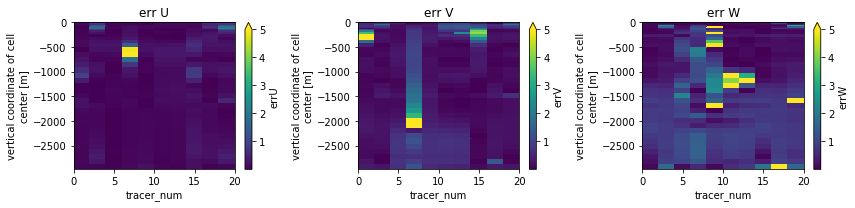

In [196]:
plt.figure(figsize=(12,3))

plt.subplot(131)
frtracer3.errU.sel( YCcoarse=yloc, XCcoarse=xloc, method='nearest').T.sel(tracer_num=slice(1,19,2)).plot(vmax=5)
plt.title('err U')

plt.subplot(132)
frtracer3.errV.sel( YCcoarse=yloc, XCcoarse=xloc, method='nearest').T.sel(tracer_num=slice(1,19,2)).plot(vmax=5)
plt.title('err V')

plt.subplot(133)
frtracer3.errW.sel( YCcoarse=yloc, XCcoarse=xloc, method='nearest').T.sel(tracer_num=slice(1,19,2)).plot(vmax=5)
plt.title('err W')

plt.tight_layout()

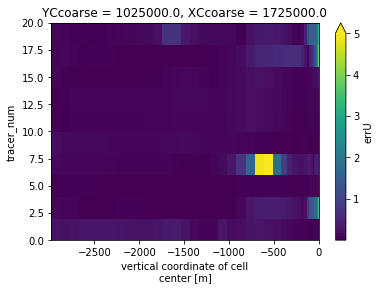

In [164]:
frtracer.errU.sel( YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2)).plot(vmax=5)


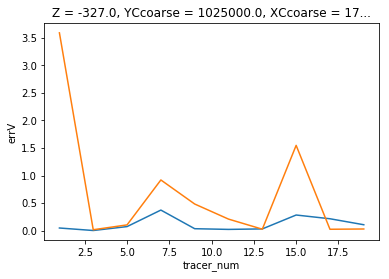

In [197]:
xloc= 1700e3
yloc = 1000e3
zloc = -300
frtracer.errU.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2)).plot()
frtracer.errV.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2)).plot()
#frtracer.errW.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2)).plot()

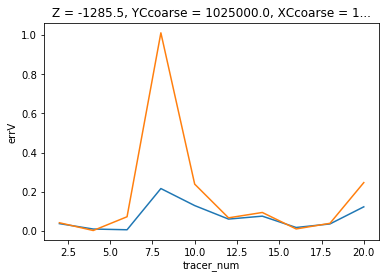

In [198]:
xloc= 1700e3
yloc = 1000e3
zloc = -1300
frtracer.errU.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2)).plot()
frtracer.errV.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2)).plot()
#frtracer.errW.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2)).plot()

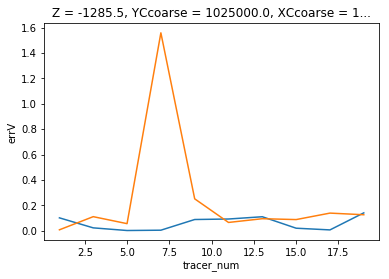

In [199]:
xloc= 1700e3
yloc = 1000e3
zloc = -1300
frtracer.errU.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2)).plot()
frtracer.errV.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2)).plot()
#frtracer.errW.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2)).plot()

### While at some level weighting improves things, it does not make a very signficant difference to the buoyancy flux errors. While it does destroy the spatial "cleanliness" of the plots.

## Check rank of the matrix 

In [32]:
import numpy.linalg as linalg

In [104]:
def calc_tensor_vec(uc,vc,wc, cx,cy,cz): 
    
    bvec = np.concatenate((uc,vc,wc))
    
    grad = np.array([cx, cy, cz]).T
    
    E1vec = np.concatenate((grad, np.zeros_like(grad), np.zeros_like(grad)), axis=1)
    E2vec = np.concatenate((np.zeros_like(grad), grad, np.zeros_like(grad)), axis=1)
    E3vec = np.concatenate((np.zeros_like(grad), np.zeros_like(grad), grad), axis=1)
    
    Evec = np.concatenate((E1vec, E2vec, E3vec), axis=0)
    
    # unsure how to set the tolerance for this
    rank = linalg.matrix_rank(Evec, tol=11e-4)
    
    K = -pinv(Evec).dot(bvec)
    
    e = (np.matmul(Evec, K) - bvec)
    
    emag = np.matmul(e, e.T)/ np.matmul(bvec, bvec.T)
    
    
    
    K = K.reshape((3,3))
    return K, emag

In [145]:
# Choose a location to do the analysis 
xloc= 1700e3
yloc = 1000e3
zloc = -300

# slow variables
yuslow= UpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))
yvslow= VpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))
ywslow= WpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))
# the number in front of E is the column number 
E1slow = dCdx.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))
E2slow = dCdy.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))
E3slow = dCdz.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))

K, err = calc_tensor_vec(yuslow, yvslow, ywslow, E1slow, E2slow, E3slow)
err**0.5

1.9924422755668643

In [123]:
K, r = calc_tensor_vec(yufast, yvfast, ywfast, E1fast, E2fast, E3fast)
r**0.5

1.9836670821803808

In [113]:
K

array([[ 7.3515547e+03,  2.5717354e+03,  1.5949976e+02],
       [ 1.3062559e+03,  8.4131348e+02,  1.8628326e+02],
       [-1.5688200e-01,  1.3419364e-01, -3.8222283e-02]], dtype=float32)

In [114]:
diff_tensor.Kslow.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest')

<xarray.DataArray 'Kslow' (i: 3, j: 3)>
array([[ 7.351562e+03,  2.571735e+03,  1.595000e+02],
       [ 1.306256e+03,  8.413139e+02,  1.862834e+02],
       [-1.543196e-01,  1.331130e-01, -3.777710e-02]], dtype=float32)
Coordinates:
    Z            float32 -5.0
    YCcoarse     float32 1025000.0
    XCcoarse     float32 725000.0
    hFacCcoarse  float32 ...
    PHrefC       float32 ...
    drF          float32 ...
Dimensions without coordinates: i, j

In [41]:
diff_tensor.eigvalsSTslow.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest')

<xarray.DataArray 'eigvalsSTslow' (ii: 3)>
array([ 6.225586e-03, -1.430513e+03,  1.471164e+04], dtype=float32)
Coordinates:
    Z            float32 -327.0
    YCcoarse     float32 1025000.0
    XCcoarse     float32 1725000.0
    hFacCcoarse  float32 ...
    PHrefC       float32 ...
    drF          float32 ...
Dimensions without coordinates: ii

# Add in constraints about buoyancy flux due to $S$ being 0

add some bit about

In [67]:
def calc_tensor_vec_constrained(uc,vc,wc, cx,cy,cz, ub,vb,wb, bx,by,bz): 
    
    bcvec = np.concatenate((uc,vc,wc))
    bbvec = np.array([0,0,0, ub, vb, wb])
    bvec = np.concatenate((bcvec,bbvec))
    
    grad = np.array([cx, cy, cz]).T
    
    E1vec = np.concatenate((grad, np.zeros_like(grad), np.zeros_like(grad)), axis=1)
    E2vec = np.concatenate((np.zeros_like(grad), grad, np.zeros_like(grad)), axis=1)
    E3vec = np.concatenate((np.zeros_like(grad), np.zeros_like(grad), grad), axis=1)
    
    Ebvec = np.array([(bx, by/2, bz/2, by/2, 0,  0,    bz/2, 0,    0),
                   (0 , bx/2, 0   , bx/2, by, bz/2, 0   , bz/2, 0),
                   (0 , 0   ,bx/2 , 0   , 0 , by/2, bx/2, by/2, bz),
                   (0 , by/2, bz/2,-by/2, 0 , 0   ,-bz/2,  0  ,  0),
                   (0 , -bx/2, 0  , bx/2 ,0 , bz/2, 0   , -bz/2, 0), 
                   (0 , 0   ,-bx/2, 0    , 0, -by/2, bx/2, by/2 ,0)])
    
    Evec = np.concatenate((E1vec, E2vec, E3vec, Ebvec), axis=0)
    
    K = -pinv(Evec).dot(bvec)
    
    K = K.reshape((3,3))
    return K

In [23]:
uc = UpCp.sel(XCcoarse=0e3, YCcoarse=1000e3, Z=-1000, method='nearest').data
vc = VpCp.sel(XCcoarse=0e3, YCcoarse=1000e3, Z=-1000, method='nearest').data
wc = WpCp.sel(XCcoarse=0e3, YCcoarse=1000e3, Z=-1000, method='nearest').data
cx = dCdx.sel(XCcoarse=0e3, YCcoarse=1000e3, Z=-1000, method='nearest').data
cy = dCdy.sel(XCcoarse=0e3, YCcoarse=1000e3, Z=-1000, method='nearest').data
cz = dCdz.sel(XCcoarse=0e3, YCcoarse=1000e3, Z=-1000, method='nearest').data

In [24]:
ub = T_coarse.UpTp.sel(XCcoarse=0e3, YCcoarse=1000e3, Z=-1000, method='nearest').data
vb = T_coarse.VpTp.sel(XCcoarse=0e3, YCcoarse=1000e3, Z=-1000, method='nearest').data
wb = T_coarse.WpTp.sel(XCcoarse=0e3, YCcoarse=1000e3, Z=-1000, method='nearest').data
bx = T_coarse.T_X.sel(XCcoarse=0e3, YCcoarse=1000e3, Z=-1000, method='nearest').data
by = T_coarse.T_Y.sel(XCcoarse=0e3, YCcoarse=1000e3, Z=-1000, method='nearest').data
bz = T_coarse.T_Z.sel(XCcoarse=0e3, YCcoarse=1000e3, Z=-1000, method='nearest').data

In [28]:
bcvec = np.concatenate((uc,vc,wc))
bbvec = np.array([0,0,0, ub, vb, wb])
bvec = np.concatenate((bcvec,bbvec))

In [30]:
bvec.shape

(66,)

In [18]:
grad = np.array([cx, cy, cz]).T

In [19]:
grad.shape

(20, 3)

In [49]:
E1vec = np.concatenate((grad, np.zeros_like(grad), np.zeros_like(grad)), axis=1)
E2vec = np.concatenate((np.zeros_like(grad), grad, np.zeros_like(grad)), axis=1)
E3vec = np.concatenate((np.zeros_like(grad), np.zeros_like(grad), grad), axis=1)

In [50]:
E1vec.shape

(20, 9)

In [47]:
Ebvec = np.array([(bx, by/2, bz/2, by/2, 0,  0,    bz/2, 0,    0),
                   (0 , bx/2, 0   , bx/2, by, bz/2, 0   , bz/2, 0),
                   (0 , 0   ,bx/2 , 0   , 0 , by/2, bx/2, by/2, bz),
                   (0 , by/2, bz/2,-by/2, 0 , 0   ,-bz/2,  0  ,  0),
                   (0 , -bx/2, 0  , bx/2 ,0 , bz/2, 0   , -bz/2, 0), 
                   (0 , 0   ,-bx/2, 0    , 0, -by/2, bx/2, by/2 ,0)])

In [48]:
Ebvec.shape

(6, 9)

In [51]:
Evec = np.concatenate((E1vec, E2vec, E3vec, Ebvec), axis=0)

In [52]:
Evec.shape

(66, 9)

In [53]:
K = -pinv(Evec).dot(bvec)

In [55]:
K = K.reshape((3,3))

In [56]:
K

array([[ 1.72253164e+03, -8.48450586e+01, -1.03937638e+00],
       [-3.53368475e+02, -6.16099275e+01, -8.89237967e-01],
       [ 9.52890382e-01,  4.09672907e-03,  5.15977415e-04]])

In [58]:
S = (K+K.T)/2
A = (K-K.T)/2

In [57]:
def calc_err(uc,vc,wc,cx,cy,cz,K):
    rU = - (K[0,0]*cx + K[0,1]*cy + K[0,2]*cz)
    rV = - (K[1,0]*cx + K[1,1]*cy + K[1,2]*cz)
    rW = - (K[2,0]*cx + K[2,1]*cy + K[2,2]*cz)    
    
    eU = np.abs(uc - rU)/np.abs(uc)
    eV = np.abs(vc - rV)/np.abs(vc)
    eW = np.abs(wc - rW)/np.abs(wc)
    
    return rU, rV, rW, eU, eV, eW

In [60]:
[rub, rvb, rwb, eub, evb, ewb] = calc_err(ub, vb,wb, bx,by,bz, K)
[rubS, rvbS, rwbS, eubS, evbS, ewbS] = calc_err(ub, vb,wb, bx,by,bz, S)
[rubA, rvbA, rwbA, eubA, evbA, ewbA] = calc_err(ub, vb,wb, bx,by,bz, A)

In [66]:
print(ub,  vb, wb)
print(rub, rvb, rwb)
print(rubS, rvbS, rwbS)
print(rubA, rvbA, rwbA)

0.0008931868 -3.5317615e-05 4.9305584e-07
0.0008622845014410845 0.0009089851664814701 -5.838770542623332e-07
-1.5448370369654418e-05 0.00047214419483106184 -2.6288262607744224e-07
0.0008777328718107387 0.0004368409716504083 -3.209944281848909e-07


In [70]:
Ktensorfast_constrained = xr.apply_ufunc(calc_tensor_vec_constrained, 
                       UpCp.sel(tracer_num=slice(1,19,2)),
                       VpCp.sel(tracer_num=slice(1,19,2)),
                       WpCp.sel(tracer_num=slice(1,19,2)),
                       dCdx.sel(tracer_num=slice(1,19,2)),
                       dCdy.sel(tracer_num=slice(1,19,2)),
                       dCdz.sel(tracer_num=slice(1,19,2)),
                       T_coarse.UpTp, T_coarse.VpTp, T_coarse.WpTp, 
                       T_coarse.T_X,  T_coarse.T_Y,  T_coarse.T_Z,
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], [],[],[],[],[],[]],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

In [75]:
Ktensorfast = xr.apply_ufunc(calc_tensor, 
                       UpCp.sel(tracer_num=slice(1,19,2)),
                       VpCp.sel(tracer_num=slice(1,19,2)),
                       WpCp.sel(tracer_num=slice(1,19,2)),
                       dCdx.sel(tracer_num=slice(1,19,2)),
                       dCdy.sel(tracer_num=slice(1,19,2)),
                       dCdz.sel(tracer_num=slice(1,19,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

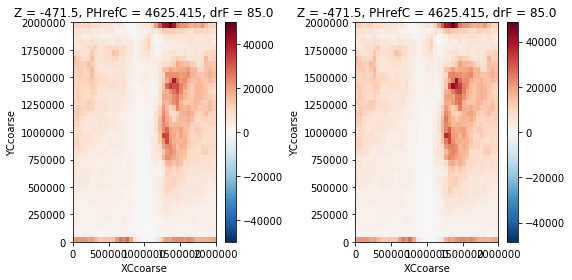

In [77]:
plt.figure(figsize=(8,4))

plt.subplot(121)
Ktensorfast_constrained.isel(i=0,j=0).sel(Z=-500, method='nearest').plot()

plt.subplot(122)
Ktensorfast.isel(i=0,j=0).sel(Z=-500, method='nearest').plot()
plt.tight_layout()

In [78]:
def flux_reconstruct(tensor, flux, grads):

    recUflux = -(tensor.sel(i=0, j=0)*grads.dCdx + tensor.sel(i=0, j=1)*grads.dCdy + tensor.sel(i=0, j=2)*grads.dCdz)
    recVflux = -(tensor.sel(i=1, j=0)*grads.dCdx + tensor.sel(i=1, j=1)*grads.dCdy + tensor.sel(i=1, j=2)*grads.dCdz)
    recWflux = -(tensor.sel(i=2, j=0)*grads.dCdx + tensor.sel(i=2, j=1)*grads.dCdy + tensor.sel(i=2, j=2)*grads.dCdz)

    errU = np.abs(flux.UpCp - recUflux)/np.abs(flux.UpCp)
    errV = np.abs(flux.VpCp - recVflux)/np.abs(flux.VpCp)
    errW = np.abs(flux.WpCp - recWflux)/np.abs(flux.WpCp)
    
    flux_rec=xr.Dataset({'UpCp':recUflux, 'VpCp':recVflux, 'WpCp':recWflux,
                                'errU':errU, 'errV':errV, 'errW':errW})
    
    return flux_rec

In [79]:
fluxT = xr.Dataset({'UpCp':T_coarse.UpTp, 'VpCp':T_coarse.VpTp, 'WpCp':T_coarse.WpTp})
gradT = xr.Dataset({'dCdx':T_coarse.T_X, 'dCdy':T_coarse.T_Y, 'dCdz':T_coarse.T_Z})
[UpCp, VpCp, WpCp] = get_flux_arrays(Trac_coarse, list_trac)
[dCdx, dCdy, dCdz]= get_grad_arrays(Trac_coarse, list_trac)
flux = xr.Dataset({'UpCp':UpCp, 'VpCp':VpCp, 'WpCp':WpCp})
grads = xr.Dataset({'dCdx':dCdx, 'dCdy':dCdy, 'dCdz':dCdz})
frtracer = flux_reconstruct(Ktensorfast, flux, grads)
frtracer_constrained = flux_reconstruct(Ktensorfast_constrained, flux, grads)
frb = flux_reconstruct(Ktensorfast, fluxT, gradT)
frb_constrained = flux_reconstruct(Ktensorfast_constrained, fluxT, gradT)

In [100]:
KtensorfastT = Ktensorfast.transpose('Z','YCcoarse','XCcoarse','j','i')

Stensorfast = 0.5*(Ktensorfast.data + KtensorfastT.data)
Atensorfast = 0.5*(Ktensorfast.data - KtensorfastT.data)

Stensorfast= xr.DataArray(Stensorfast, coords=Ktensorfast.coords, dims=Ktensorfast.dims)
Atensorfast = xr.DataArray(Atensorfast, coords=Ktensorfast.coords, dims=Ktensorfast.dims)

In [102]:
Ktensorfast_constrainedT = Ktensorfast_constrained.transpose('Z','YCcoarse','XCcoarse','j','i')

Stensorfast_constrained = 0.5*(Ktensorfast_constrained.data + Ktensorfast_constrainedT.data)
Atensorfast_constrained = 0.5*(Ktensorfast_constrained.data - Ktensorfast_constrainedT.data)

Stensorfast_constrained= xr.DataArray(Stensorfast_constrained, coords=Ktensorfast_constrained.coords, dims=Ktensorfast_constrained.dims)
Atensorfast_constrained = xr.DataArray(Atensorfast_constrained, coords=Ktensorfast_constrained.coords, dims=Ktensorfast_constrained.dims)

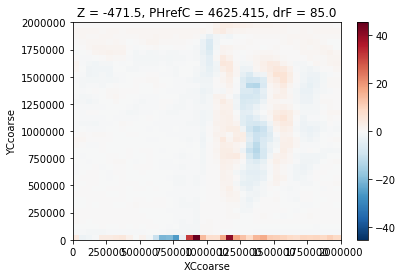

In [103]:
Atensorfast_constrained.sel(Z=-500, method='nearest').isel(i=0,j=2).plot()

In [104]:
frbS = flux_reconstruct(Stensorfast, fluxT, gradT)
frbS_constrained = flux_reconstruct(Stensorfast_constrained, fluxT, gradT)
frbA = flux_reconstruct(Atensorfast, fluxT, gradT)
frbA_constrained = flux_reconstruct(Atensorfast_constrained, fluxT, gradT)

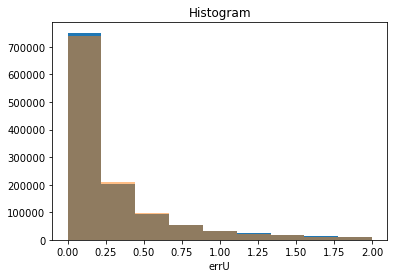

In [83]:
bins = np.linspace(0,2,10)
[_,_,_] = frtracer.errU.plot.hist(bins=bins)
[_,_,_] = frtracer_constrained.errU.plot.hist(bins=bins, alpha=0.5)

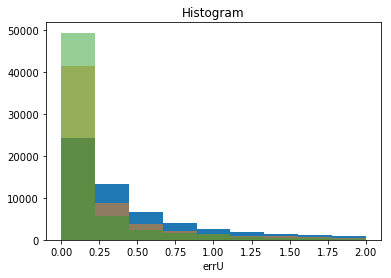

In [109]:
bins = np.linspace(0,2,10)
[_,_,_] = frb.errU.plot.hist(bins=bins)
[_,_,_] = frb_constrained.errU.plot.hist(bins=bins, alpha=0.5)
[_,_,_] = frbA_constrained.errU.plot.hist(bins=bins, alpha=0.5)


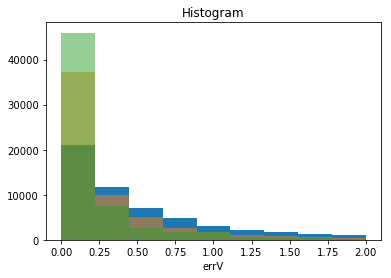

In [110]:
bins = np.linspace(0,2,10)
[_,_,_] = frb.errV.plot.hist(bins=bins)
[_,_,_] = frb_constrained.errV.plot.hist(bins=bins, alpha=0.5)
[_,_,_] = frbA_constrained.errV.plot.hist(bins=bins, alpha=0.5)

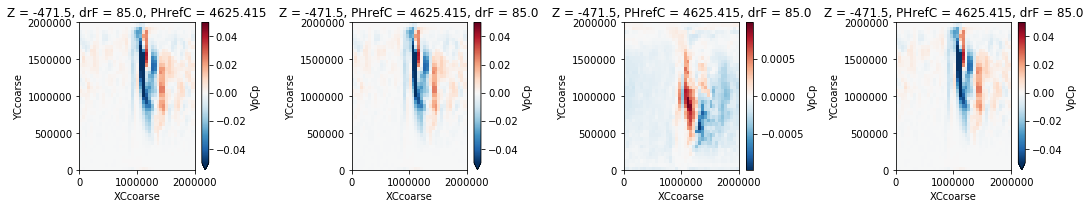

In [112]:
plt.figure(figsize=(15,3))


plt.subplot(141)
fluxT.VpCp.sel(Z=-500, method='nearest').plot(vmin=-0.05)

plt.subplot(142)
frb_constrained.VpCp.sel(Z=-500, method='nearest').plot(vmin=-0.05)

plt.subplot(143)
frbS_constrained.VpCp.sel(Z=-500, method='nearest').plot()

plt.subplot(144)
frbA_constrained.VpCp.sel(Z=-500, method='nearest').plot(vmin=-0.05)

plt.tight_layout()

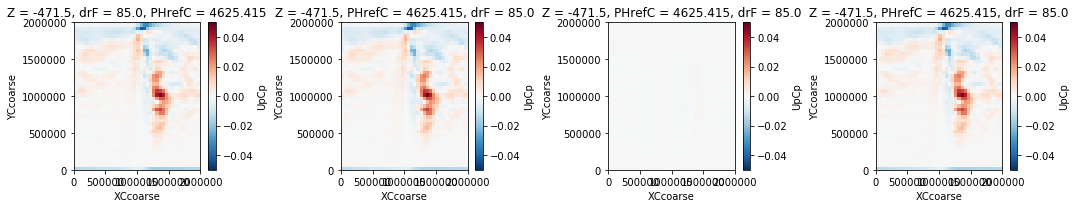

In [108]:
plt.figure(figsize=(15,3))


plt.subplot(141)
fluxT.UpCp.sel(Z=-500, method='nearest').plot(vmin=-0.05)

plt.subplot(142)
frb_constrained.UpCp.sel(Z=-500, method='nearest').plot(vmin=-0.05)

plt.subplot(143)
frbS_constrained.UpCp.sel(Z=-500, method='nearest').plot(vmin=-0.05)

plt.subplot(144)
frbA_constrained.UpCp.sel(Z=-500, method='nearest').plot(vmin=-0.05)

plt.tight_layout()